# 3. MLP基礎（バッチ編）

## 概要
この試験ではChapter03で学習した、深層学習の基礎である多層パーセプトロン(バッチ処理)を穴埋め形式で実装します。<br>
予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
試験問題文は<font color="Red">赤字</font>で表示されています。<br>
また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：5~8時間

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if "google.colab" in sys.modules:
    print("Google Colab")
    # ライブラリのインストール
    # 必要なライブラリをインストールするコードを記載
else:
    print("Not Google Colab")

Not Google Colab


### ライブラリのインポート
必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline
# 乱数シードを指定
np.random.seed(seed=0)

今回もデータセットとしてMNISTを使用し、`sklearn`の`train_test_split`を用いて訓練データ:テストデータ = 8:2 に分割します。

In [3]:
# mnistデータセットのロード(ネットワーク接続が必要・少し時間がかかります)
if os.path.exists("mnist_784"):
    with open("mnist_784", "rb") as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml("mnist_784", as_frame=False)
    with open("mnist_784", "wb") as f:
        pickle.dump(mnist, f)
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)

# ラベルデータをint型にし、one-hot-vectorに変換します
t_train = np.eye(10)[t_train.astype("int")]
t_test = np.eye(10)[t_test.astype("int")]

## 最適化・バッチ正規化・ミニバッチ学習（スクラッチ）

#### データのサンプリング
画像・ラベルデータをランダムにいくつか取り出して可視化します。
画像は784要素の1次元ベクトルとしてXに格納されていますが、画像として表示するときは28x28の二次元にreshapeします。

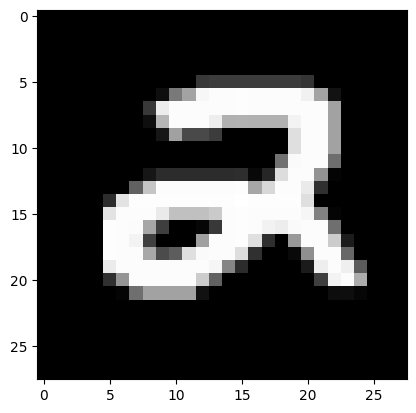

Label:  2


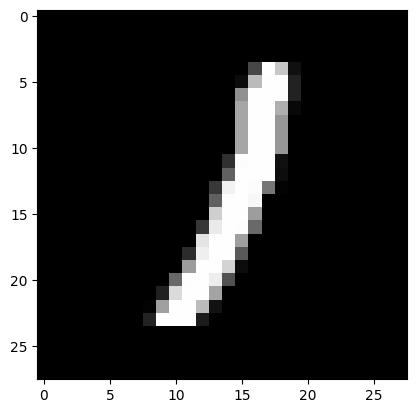

Label:  1


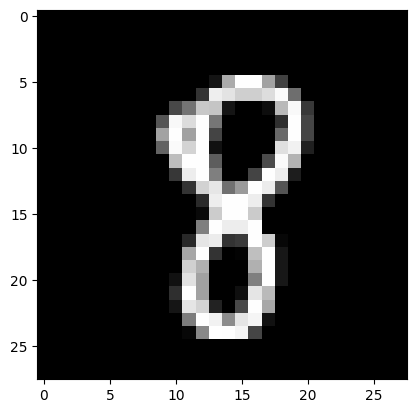

Label:  8


In [4]:
# テストデータをランダムサンプリング
perm = np.random.permutation(len(x_test))
# サンプル画像を表示する
plt.gray()
for i in perm[:3]:
    plt.imshow(x_test[perm[i]].reshape(28, 28))
    plt.show()
    print("Label: ", np.argmax(t_test[perm[i]]))

### Optimizerの実装

* <font color="Red">問1. 確率的勾配降下法を用いたOptimizerのクラス SGD を完成させてください。</font><br>
SGDの特徴として、データを変えることによって、損失関数自体を確率的に変えることができることが挙げられます。これによって、パラメータは同じであっても、勾配の向きを確率的に換えることができます。
この問題ではSGDのコードを回答してください。

In [5]:
class SGD:
    """確率的勾配降下法 (SGD: Stochastic Gradient Descent) オプティマイザ。

    Attributes:
        lr (float): 学習率。
    """

    def __init__(self, lr=0.01):
        """SGDの初期化メソッド。

        Args:
            lr (float, optional): 学習率。デフォルトは0.01。
        """
        self.lr = lr

    def update(self, params, grads):
        """与えられた勾配に基づいてパラメータを更新する。

        Args:
            params (dict): 更新するパラメータを含む辞書。keyはパラメータの名前、valueはパラメータのndarray。
            grads (dict): 各パラメータに対する勾配を含む辞書。keyはパラメータの名前、valueは勾配のndarray。
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key] ### 問1 ###

* <font color="Red">問2. Adamクラス を完成させてください。</font><br>
Adamの特徴としてハイパーパラメータのバイアス補正(偏りの補正)が行われることが挙げられます。書籍『ゼロから作るDeepLearning』の配布コードは簡易版のため、バイアス補正を組み込んでいません。<br>
この問題ではバイアス補正を組み込んだ完成形のAdamコードについて回答してください。また、過去のE資格試験ではこちらの完成形のAdamコードが出題されています。

In [6]:
class Adam:
    """Adam (Adaptive moment estimation) オプティマイザ。

    Attributes:
        lr (float): 学習率。
        beta1 (float): 1つ目のモーメンタムの減衰係数。
        beta2 (float): 2つ目のモーメンタムの減衰係数。
        iter (int): 更新回数。
        m (dict): 1次モーメンタム。
        v (dict): 2次モーメンタム。
    """

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        """Adamの初期化メソッド。

        Args:
            lr (float, optional): 学習率。デフォルトは0.001。
            beta1 (float, optional): 1つ目のモーメンタムの減衰係数。デフォルトは0.9。
            beta2 (float, optional): 2つ目のモーメンタムの減衰係数。デフォルトは0.999。
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        """与えられた勾配に基づいてパラメータを更新する。

        Args:
            params (dict): 更新するパラメータを含む辞書。keyはパラメータの名前、valueはパラメータのndarray。
            grads (dict): 各パラメータに対する勾配を含む辞書。keyはパラメータの名前、valueは勾配のndarray。
        """
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1

        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key] ###### 問2-1 ######
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * grads[key] ** 2 ###### 問2-2 ######
            m_unbias = self.m[key] / (1 - self.beta1 ** self.iter) ###### 問2-3 ######
            v_unbias = self.v[key] / (1 - self.beta2 ** self.iter) ###### 問2-4 ######
            params[key] -= self.lr * m_unbias / (np.sqrt(v_unbias) + 1e-7)

#### コスト関数

多クラス分類問題なので、クロスエントロピーをコスト関数として用います。

In [7]:
def cross_entropy_error(y, t):
    """交差エントロピー誤差の計算。

    この関数は、ネットワークの出力と正解ラベルとの間の交差エントロピー誤差を計算します。
    1次元の入力にも対応しており、内部で適切な形状に変形します。
    正解ラベルがone-hotベクトルの場合、ラベルとして最も確率が高いインデックスに変換します。

    Args:
        y (ndarray): ネットワークの出力（予測）。
        t (ndarray): 正解のラベル（one-hotベクトルまたはラベルインデックス）。

    Returns:
        float: 交差エントロピー誤差。
    """
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [8]:
def softmax(x):
    """ソフトマックス関数を適用。

    この関数は、入力されたndarrayに対してソフトマックス関数を適用します。
    数値のオーバーフローを防ぐために、各要素から最大値を減算してからソフトマックス計算を行います。

    Args:
        x (ndarray): ソフトマックス関数を適用する前の数値。

    Returns:
        ndarray: ソフトマックス関数を適用した後の数値。

    Raises:
        ValueError: 入力xがndarrayではない場合。
        ValueError: 入力xが適切な形状でない場合。
    """
    x = x.T
    x = x - np.max(x, axis=0)
    x = np.exp(x) / np.sum(np.exp(x), axis=0)
    return x.T

### バッチ正規化を用いないMLP

まずはバッチ正規化を入れない普通の三層ニューラルネットワークを実装します。問題にはなっていませんが、chapter02の復習も兼ねてコードを読み理解しておいてください。

In [9]:
class mnistMultiLayerNet:
    """5層の隠れ層を持つ深いニューラルネットワーク。MNISTデータセットの手書き数字分類に使用する。

    Attributes:
        input_size (int): 入力層のサイズ。
        output_size (int): 出力層のサイズ。
        hidden_size_list (list of int): 隠れ層のサイズのリスト。
        all_size_list (list of int): 全層のサイズのリスト。
        hidden_layer_num (int): 隠れ層の数。
        weight_decay_lambda (float): 重み減衰のλ。
        params (dict): 重みとバイアスを持つ辞書。
        layers (dict): 各層のアクティベーションを持つ辞書。
        grads (dict): 各層の勾配を持つ辞書。


    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """

    def __init__(self):
        """
        mnistMultiLayerNetの初期化メソッド。
        """
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = (
            [self.input_size] + self.hidden_size_list + [self.output_size]
        )
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda = 0
        self.params = {}
        self.layers = {}
        self.grads = {}

        # 重みとバイアスの初期化
        for idx in range(1, len(self.all_size_list)):
            self.params["w" + str(idx)] = (
                np.random.randn(self.all_size_list[idx - 1], self.all_size_list[idx])
                * 0.085
            )
            self.params["b" + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)

    def forward(self, x):
        """ネットワークの順伝播。

        Args:
            x (ndarray): 入力データ。

        Returns:
            ndarray: 出力層のアクティベーション。
        """
        relu = lambda x: np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers["layer0"] = x
        for idx in range(1, len(self.all_size_list) - 1):
            w = self.params["w" + str(idx)]
            b = self.params["b" + str(idx)]
            x = self.layers["layer" + str(idx - 1)]
            self.layers["layer" + str(idx)] = relu(np.dot(x, w) + b)
        idx = len(self.all_size_list) - 1
        w = self.params["w" + str(idx)]
        b = self.params["b" + str(idx)]
        x = self.layers["layer" + str(idx - 1)]
        self.layers["layer" + str(idx)] = softmax(np.dot(x, w) + b)

        return self.layers["layer" + str(idx)]

    def loss(self, y, t):
        """損失関数の計算。

        Args:
            y (ndarray): ネットワークの出力。
            t (ndarray): 正解のラベル。

        Returns:
            float: 交差エントロピー誤差。
        """
        return cross_entropy_error(y, t)

    def backward(self, t, y):
        """ネットワークの逆伝播。

        Args:
            t (ndarray): 正解のラベル。
            y (ndarray): ネットワークの出力。

        Returns:
            dict: 各層の勾配を持つ辞書。
        """
        delta = (y - t) / t.shape[0]
        self.grads["b5"] = np.sum(delta, axis=0)
        self.grads["w5"] = np.dot(self.layers["layer4"].transpose(), delta)
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params["w" + str(idx + 1)].transpose())
            delta = delta * (self.layers["layer" + str(idx)] > 0)
            self.grads["b" + str(idx)] = np.sum(delta, axis=0)
            self.grads["w" + str(idx)] = np.dot(
                self.layers["layer" + str(idx - 1)].transpose(), delta
            )
        return self.grads


## バッチ正規化を用いたMLP
* <font color="Red">問3. バッチ正規化を用いたMLPクラスを完成させる</font>
  * <font color="Red">問3-1. 【forward関数】ミニバッチの平均を算出する処理を記述してください。</font>
  * <font color="Red">問3-2. 【forward関数】ミニバッチの分散を算出する処理を記述してください。</font>
  * <font color="Red">問3-3. 【forward関数】移動平均により全体の平均を求める処理を記述してください。</font>
  * <font color="Red">問3-4. 【forward関数】移動平均により全体の分散を求める処理を記述してください。</font>
  * <font color="Red">問3-5. 【forward関数】テスト時にデータから全体の平均を引く処理を記述してください。</font>
  * <font color="Red">問3-6. 【forward関数】テスト時にデータを正規化する処理を記述してください。</font>
  * <font color="Red">問3-7. 【backward関数】βの勾配を算出する処理を記述してください。</font>
  * <font color="Red">問3-8. 【backward関数】γの勾配を算出する処理を記述してください。</font>

各層について、重みを掛けて足し合わせた後バッチ正規化を行う。

  バッチ正規化の順伝播は以下の式に従って実装します。
  
  - （訓練時のみ）まずは計算しているミニバッチについて、平均と分散を求めます。各次元について、全データを通じた平均・分散を計算するため、平均・分散を計算する軸にご注意ください。

  - （訓練時のみ）テスト時に使用するために、訓練データ全体での平均を推定します。モーメンタム $m$ を用いて今までの平均 $\mu_{old} $ を計算しているミニバッチの平均 $\mu$ の方向に移動させ、新しい平均$\mu_{new} $を求めます。
  $$
  \mu_{new} = m \mu_{old} + ( 1 - m)\mu\tag{1}
  $$

  - （訓練時のみ）同様に今までの分散 $\sigma_{old} ^ 2$ を計算しているミニバッチの平均 $\sigma^2$の方向に移動させ、 新しい分散$\sigma_{new}^2$ を求めます。
  $$
  \sigma_{new}^2 = m \sigma_{old}^2 + ( 1 - m)\sigma^2\tag{2}
  $$

  - 求めた平均 $\mu$ と分散 $\sigma^2$ を用いて、入力 $x$ を正規化した値 $x_n$ を求めます。分散$\sigma^2$から標準偏差 $\sigma$ を求めるときに、アンダーフローを避けるために 1e-6 ($10 ^ {-6}$) を足してから平方根を取っています。
  テスト時には、移動平均により推定した訓練データ全体での平均・分散を使用します。
  $$
  \sigma = \sqrt{\sigma ^ 2 + 10 ^ {-6}}\tag{3}
  $$
  $$
  x_n = (x - \mu) / \sigma\tag{4}
  $$

   - 正規化した値 $x_n$に対して $\gamma$ を用いて変倍し、$\beta$ を用いて移動を行い、活性化関数に渡す出力 $y$ を求めます。
   $$
   y = \gamma x_n + \beta\tag{5}
   $$
 
   バッチ正規化の誤差逆伝播は以下の式に従って実装します。
   
   - 直前まで逆伝播してきた$1, 2, \dots , N$ 番目(Nはバッチサイズ)の出力データ$y_k$による勾配 $\frac{\partial L}{\partial y_k}$を用いて $\gamma$ と$\beta$による勾配を計算します。 $x_{nk}$ はミニバッチの中のk番目の入力データを正規化した後の値を表します。
   $$
   \begin{align}
   \frac{\partial L}{\partial \gamma} & = \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \gamma} = \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} x_{nk}\tag{6}\\
   \frac{\partial L}{\partial \beta} & = \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \beta} = \sum_{k=1}^{N} \frac{\partial L}{\partial y_k}\tag{7}
   \end{align}
   $$
   
   - $1, 2, \dots , N$ 番目の入力データ$x_k$による勾配 $\frac{\partial L}{\partial x_k}$を計算します（コードでは高速化のため少々異なった計算をしています）。
   
   $$
  \begin{equation} 
  \frac{\partial L}{\partial x_k} 
  = \frac{\gamma}{\sigma} \Bigg[ \frac{\partial L}{\partial y_k} 
  - \frac{1}{N} \bigg[ \frac{\partial L}{\partial \beta} + x_{nk} \frac{\partial L}{\partial \gamma} \bigg] \Bigg] 
  \end{equation}
  $$

In [10]:
class mnistMultiLayerBatchNet:
    """MNISTデータセット用の多層ニューラルネットワーククラス。バッチ正規化を使用しています。

    Attributes:
        input_size (int): 入力層のニューロン数。
        output_size (int): 出力層のニューロン数。
        hidden_size_list (list of int): 各隠れ層のニューロン数のリスト。
        all_size_list (list of int): 全ての層のニューロン数のリスト。
        hidden_layer_num (int): 隠れ層の数。
        weight_decay_lambda (float): 重みの減衰のためのパラメータ。
        params (dict): ネットワークのパラメータを保持する辞書。
        layers (dict): 各層のアクティベーションを保持する辞書。
        grads (dict): 勾配を保持する辞書。
        norms (dict): バッチ正規化に関連する情報を保持する辞書。
        momentum (float): 移動平均のモメンタム。



    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓バッチ正規化 gamma1倍しbeta1だけずらす
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓バッチ正規化 gamma2倍しbeta2だけずらす
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓バッチ正規化 gamma3倍しbeta3だけずらす
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓バッチ正規化 gamma4倍しbeta4だけずらす
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """

    def __init__(self):
        """mnistMultiLayerBatchNetクラスの初期化を行います。
        """
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = (
            [self.input_size] + self.hidden_size_list + [self.output_size]
        )
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda = 0
        self.params = {}
        self.layers = {}
        self.grads = {}
        self.norms = {}
        self.momentum = 0.9

        # パラメータの初期化
        for idx in range(1, len(self.all_size_list)):
            # 線形結合層のパラメータ
            self.params["w" + str(idx)] = (
                np.random.randn(self.all_size_list[idx - 1], self.all_size_list[idx])
                * 0.085
            )
            self.params["b" + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)

            # バッチ正規化でシフトさせるときに用いるγとβを更新するパラメータとし初期化
            # mu と sigma は実行時の平均と分散
            if idx != len(self.all_size_list) - 1:
                self.params["gamma" + str(idx)] = np.ones(self.all_size_list[idx])
                self.params["beta" + str(idx)] = np.zeros(self.all_size_list[idx])
                self.norms["mu" + str(idx)] = None
                self.norms["var" + str(idx)] = None

    def forward(self, x, train_flg=False):
        """ネットワークの順伝播を行います。

        Args:
            x (numpy.ndarray): 入力データ。
            train_flg (bool, optional): トレーニング中の場合はTrue。デフォルトはFalse。

        Returns:
            numpy.ndarray: ネットワークの出力。
        """
        relu = lambda x: np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers["layer0"] = x
        for idx in range(1, len(self.all_size_list) - 1):
            # 線形結合層
            w = self.params["w" + str(idx)]
            b = self.params["b" + str(idx)]
            x = self.layers["layer" + str(idx - 1)]
            x = np.dot(x, w) + b

            # バッチ正規化
            # 平均と分散の初期化
            if self.norms["mu" + str(idx)] is None:
                N, D = x.shape
                self.norms["mu" + str(idx)] = np.zeros(D)
                self.norms["var" + str(idx)] = np.zeros(D)
            if train_flg:
                mu = x.mean(axis=0) ###### 問3-1 ######
                xc = x - mu  # 今回のミニバッチの平均との差分
                var = (xc ** 2).mean(axis=0)  ###### 問3-2 ######
                std = np.sqrt(var + 1e-6)  # 今回のミニバッチの標準偏差
                xn = xc / std  # 正規化

                # 全体の平均と分散を移動平均により求める(1),(2)
                self.norms["mu" + str(idx)] = self.momentum * self.norms['mu' + str(idx)] + (1 - self.momentum) * mu ###### 問3-3 ######
                self.norms["var" + str(idx)] = self.momentum * self.norms['var' + str(idx)] + (1 - self.momentum) * var###### 問3-4 ######

                # 誤差逆伝播で使う中間データ
                self.norms["xc" + str(idx)] = xc
                self.norms["xn" + str(idx)] = xn
                self.norms["std" + str(idx)] = std
                self.norms["size" + str(idx)] = x.shape[0]
            else:
                # テスト時は全体の平均と分散を使って正規化する(3),(4)
                xc = x - self.norms['mu' + str(idx)] ###### 問3-5 ######
                xn = xc / np.sqrt(self.norms['var' + str(idx)] + 1e-6) ###### 問3-6 ######

            # γ,βを用いてシフトさせる(5)
            shifted = (
                self.params["gamma" + str(idx)] * xn + self.params["beta" + str(idx)]
            )

            # relu を使って活性化
            self.layers["layer" + str(idx)] = relu(shifted)

        # 出力層
        idx = len(self.all_size_list) - 1
        w = self.params["w" + str(idx)]
        b = self.params["b" + str(idx)]
        x = self.layers["layer" + str(idx - 1)]
        self.layers["layer" + str(idx)] = softmax(np.dot(x, w) + b)

        return self.layers["layer" + str(idx)]

    def loss(self, y, t):
        """クロスエントロピー誤差を計算します。

        Args:
            y (numpy.ndarray): ネットワークの出力。
            t (numpy.ndarray): 正解ラベル。

        Returns:
            float: クロスエントロピー誤差。
        """
        return cross_entropy_error(y, t)

    def backward(self, t, y):
        """誤差逆伝播を通じて、パラメータの勾配を計算します。

        Args:
            t (numpy.ndarray): 正解ラベル。
            y (numpy.ndarray): ネットワークの出力。

        Returns:
            dict: 各パラメータの勾配。
        """
        # 出力層における誤差の勾配（クロスエントロピー関数の勾配）
        delta = (y - t) / t.shape[0]

        # 出力層手前の線形結合層における勾配の逆伝播
        self.grads["b5"] = np.sum(delta, axis=0)
        self.grads["w5"] = np.dot(self.layers["layer4"].transpose(), delta)

        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params["w" + str(idx + 1)].transpose())

            # relu の微分
            delta = delta * (self.layers["layer" + str(idx)] > 0)

            # バッチ正規化における勾配の逆伝播(6),(7)
            self.grads["beta" + str(idx)] = np.sum(delta, axis=0) ###### 問3-7 ######
            self.grads["gamma" + str(idx)] = np.sum(delta * self.norms['xn' + str(idx)], axis=0) ###### 問3-8 ######
            dxn = self.params["gamma" + str(idx)] * delta
            dxc = dxn / self.norms["std" + str(idx)]
            dstd = -np.sum(
                (dxn * self.norms["xc" + str(idx)])
                / (self.norms["std" + str(idx)] * self.norms["std" + str(idx)]),
                axis=0,
            )
            dvar = 0.5 * dstd / self.norms["std" + str(idx)]
            dxc += (
                (2.0 / self.norms["size" + str(idx)])
                * self.norms["xc" + str(idx)]
                * dvar
            )
            dmu = np.sum(dxc, axis=0)
            delta = dxc - dmu / self.norms["size" + str(idx)]

            # 線形結合層における勾配の逆伝播
            self.grads["b" + str(idx)] = np.sum(delta, axis=0)
            self.grads["w" + str(idx)] = np.dot(
                self.layers["layer" + str(idx - 1)].transpose(), delta
            )

        return self.grads


### ミニバッチを用いた学習

ミニバッチを用いた学習を行います。

* <font color="Red">問4. ランダムサンプリングのためにインデックスをランダムに読み込む処理を記述しましょう。</font>
* <font color="Red">問5. バッチサイズごとに入力と教師データを読み込む処理を記述しましょう。</font>

ヒント: numpy.random.permutation を用いることで、データのインデックスをシャッフルした配列を用意することで、シャッフルインデックス配列permに対して、前からバッチサイズずつインデックスを切り出せばミニバッチの抽出が行えます。

また、学習用のコードは実行に時間がかかります。完了するまで5~10分ほどを要しますのでご注意ください。


In [11]:
bn = mnistMultiLayerBatchNet()
nobn = mnistMultiLayerNet()
adambn = mnistMultiLayerBatchNet()
adamnobn = mnistMultiLayerNet()

bn_acc_list = []
nobn_acc_list = []
adambn_acc_list = []
adamnobn_acc_list = []

sgd = SGD(lr=0.01)
adam = Adam(lr=0.01)

sgd_norm = SGD(lr=0.01)
adam_norm = Adam(lr=0.01)

# ミニバッチアルゴリズム
batch_size = 128

In [14]:
for epoch in range(20):
    # ランダムにミニバッチを読み込むために、インデックスをランダムに並び替える
    perm = np.random.permutation(len(x_train))### 問4 ###
    # batch_size ごとにデータを読み込んで学習させる
    for idx in np.arange(0, len(perm), batch_size):
        x = x_train[perm[idx : idx + batch_size]]### 問5-1 ###
        t = t_train[perm[idx : idx + batch_size]]### 問5-2 ###

        y = bn.forward(x, train_flg=True)
        grads = bn.backward(t, y)
        sgd_norm.update(bn.params, grads)

        y = adambn.forward(x, train_flg=True)
        grads = adambn.backward(t, y)
        adam_norm.update(adambn.params, grads)

        y = nobn.forward(x)
        grads = nobn.backward(t, y)
        sgd.update(nobn.params, grads)

        y = adamnobn.forward(x)
        grads = adamnobn.backward(t, y)
        adam.update(adamnobn.params, grads)

    y_test = bn.forward(x_test)
    bn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = nobn.forward(x_test)
    nobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adambn.forward(x_test)
    adambn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adamnobn.forward(x_test)
    adamnobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())

    print(
        f"EPOCH {epoch + 1} | NoBatch ACCURACY (SGD) {nobn_acc_list[-1]:.2%} | Batch ACCURACY (SGD){bn_acc_list[-1]:.2%} | NoBatch ACCURACY (Adam){adamnobn_acc_list[-1]:.2%} | Batch ACCURACY (Adam) {adambn_acc_list[-1]:.2%}"
    )

EPOCH 1 | NoBatch ACCURACY (SGD) 87.13% | Batch ACCURACY (SGD)85.26% | NoBatch ACCURACY (Adam)89.48% | Batch ACCURACY (Adam) 95.78%
EPOCH 2 | NoBatch ACCURACY (SGD) 90.37% | Batch ACCURACY (SGD)89.98% | NoBatch ACCURACY (Adam)91.53% | Batch ACCURACY (Adam) 96.59%
EPOCH 3 | NoBatch ACCURACY (SGD) 92.39% | Batch ACCURACY (SGD)91.75% | NoBatch ACCURACY (Adam)92.41% | Batch ACCURACY (Adam) 96.94%
EPOCH 4 | NoBatch ACCURACY (SGD) 92.90% | Batch ACCURACY (SGD)92.79% | NoBatch ACCURACY (Adam)93.21% | Batch ACCURACY (Adam) 96.99%
EPOCH 5 | NoBatch ACCURACY (SGD) 93.61% | Batch ACCURACY (SGD)93.34% | NoBatch ACCURACY (Adam)93.34% | Batch ACCURACY (Adam) 97.19%
EPOCH 6 | NoBatch ACCURACY (SGD) 93.30% | Batch ACCURACY (SGD)94.04% | NoBatch ACCURACY (Adam)93.56% | Batch ACCURACY (Adam) 97.63%
EPOCH 7 | NoBatch ACCURACY (SGD) 93.77% | Batch ACCURACY (SGD)94.39% | NoBatch ACCURACY (Adam)92.30% | Batch ACCURACY (Adam) 97.29%
EPOCH 8 | NoBatch ACCURACY (SGD) 94.11% | Batch ACCURACY (SGD)94.67% | NoBat

### 学習結果
学習結果を可視化してみます。まずはSGDを使った学習についてのみ比較を行います。結果のグラフが以下のグラフと一致していれば学習は成功しています。

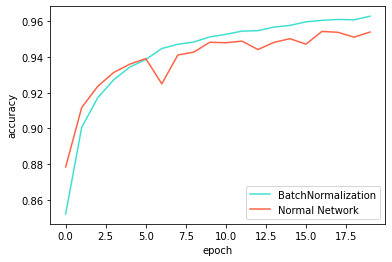
学習結果からわかる通り、バッチ正規化を加えることでテスト精度が高い水準で安定させることが可能となります。

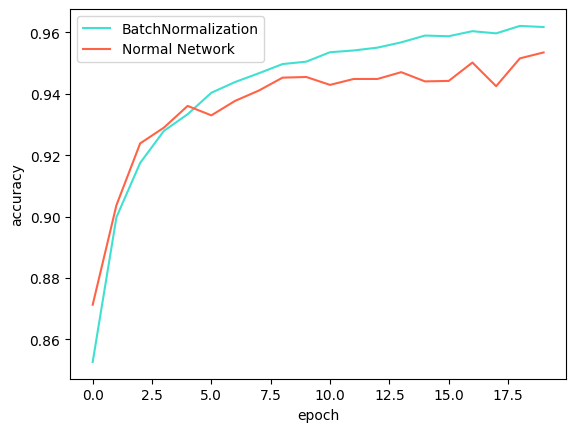

In [15]:
epochs = range(20)
plt.plot(epochs, bn_acc_list, color="turquoise")
plt.plot(epochs, nobn_acc_list, color="tomato")

plt.legend(["BatchNormalization", "Normal Network"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

次にAdamで学習した場合も含めてプロットしてみましょう。結果のグラフの特徴が以下と一致していれば学習成功です。<br>
・Adamで学習すると、SGDよりも学習が進みやすく、高い精度が実現できている。<br>
・バッチ正規化を加えないネットワークでは過学習により途中からテスト精度が急に低下している。<br>
バッチ正規化を加えることで正則化の役割も可能となっていることが読み取れます。

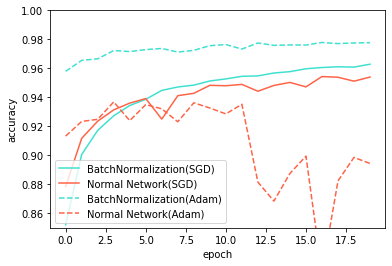

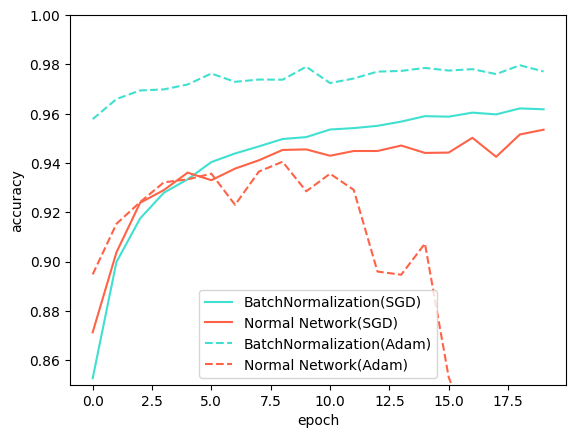

In [16]:
epochs = range(20)
plt.plot(epochs, bn_acc_list, color="turquoise", linestyle="-")
plt.plot(epochs, nobn_acc_list, color="tomato", linestyle="-")
plt.plot(epochs, adambn_acc_list, color="turquoise", linestyle="--")
plt.plot(epochs, adamnobn_acc_list, color="tomato", linestyle="--")

plt.ylim((0.85, 1))

plt.legend(
    [
        "BatchNormalization(SGD)",
        "Normal Network(SGD)",
        "BatchNormalization(Adam)",
        "Normal Network(Adam)",
    ]
)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()